In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, shapiro
import pandas as pd
from copulas.multivariate import GaussianMultivariate
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler


In [2]:
np.random.seed(2025)

In [3]:
data = pd.read_csv("../../datos/FINAL/datos_grasas_Tec_limpio.csv", encoding="utf-8")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   idDatosGrasas                             51 non-null     int64  
 1   codigoGrasa                               51 non-null     object 
 2   Aceite Base                               47 non-null     object 
 3   Espesante                                 45 non-null     object 
 4   Grado NLGI Consistencia                   51 non-null     float64
 5   Viscosidad del Aceite Base a 40°C. cSt    50 non-null     float64
 6   Penetración de Cono a 25°C, 0.1mm         51 non-null     float64
 7   Punto de Gota, °C                         51 non-null     int64  
 8   Estabilidad Mecánica, %                   48 non-null     float64
 9   Punto de Soldadura Cuatro Bolas, kgf      50 non-null     float64
 10  Desgaste Cuatro Bolas, mm               

In [5]:
# drop non-numeric columns
data = data.select_dtypes(include=[np.number])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   idDatosGrasas                             51 non-null     int64  
 1   Grado NLGI Consistencia                   51 non-null     float64
 2   Viscosidad del Aceite Base a 40°C. cSt    50 non-null     float64
 3   Penetración de Cono a 25°C, 0.1mm         51 non-null     float64
 4   Punto de Gota, °C                         51 non-null     int64  
 5   Estabilidad Mecánica, %                   48 non-null     float64
 6   Punto de Soldadura Cuatro Bolas, kgf      50 non-null     float64
 7   Desgaste Cuatro Bolas, mm                 27 non-null     float64
 8   Indice de Carga-Desgaste                  10 non-null     float64
 9   Carga Timken Ok, lb                       46 non-null     float64
 10  Resistencia al Lavado por Agua a 80°C, %

In [7]:
data = data.drop(columns=['idDatosGrasas', 'Registro NSF', 'Indice de Carga-Desgaste'])

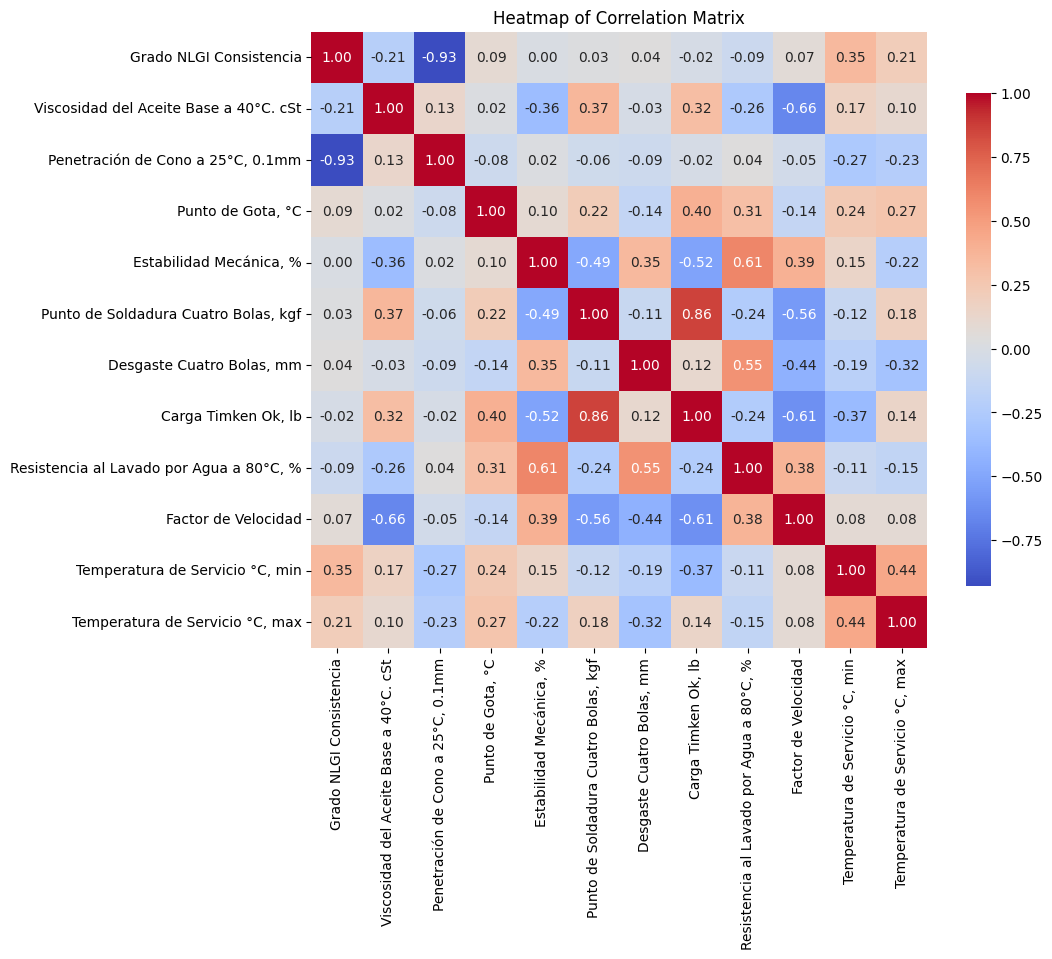

In [8]:
# heat map
plt.figure(figsize=(10, 8))
plt.title('Heatmap of Correlation Matrix')
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.show()

In [9]:
data_new = data[['Viscosidad del Aceite Base a 40°C. cSt', 'Carga Timken Ok, lb', 'Penetración de Cono a 25°C, 0.1mm', 'Punto de Gota, °C', 'Punto de Soldadura Cuatro Bolas, kgf', 'Estabilidad Mecánica, %', 'Resistencia al Lavado por Agua a 80°C, %', 'Temperatura de Servicio °C, min', 'Temperatura de Servicio °C, max']]

In [10]:
def simular_datos_copula(df_original, n_new=1000, n_neighbors=8):
    """
    Genera datos sintéticos usando una Copula Gaussiana.

    Parámetros:
        df_original, DataFrame a expandir
        n_nuevos, Cantidad de datos generados
        n_neighbors, Número de vecinos para KNNImputer

    Retorna:
        df_expanded : DataFrame expandido con datos simulados.

    """

    df = df_original

    # Imputar NaNs
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputado = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Entrenar la copula gaussiana
    model = GaussianMultivariate()
    model.fit(df_imputado)

    # Simular datos
    df_expanded = model.sample(n_new)

    return df_expanded

In [11]:
data_expanded = simular_datos_copula(data_new, n_new=1449, n_neighbors=3)

c:\Users\GustavoAguilar\anaconda3\envs\movie-reco\Lib\site-packages\scipy\stats\_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\GustavoAguilar\anaconda3\envs\movie-reco\Lib\site-packages\scipy\stats\_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\GustavoAguilar\anaconda3\envs\movie-reco\Lib\site-packages\scipy\stats\_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\GustavoAguilar\anaconda3\envs\movie-reco\Lib\site-packages\scipy\stats\_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\Gustavo

In [12]:
holdout_size = 0.2
n_holdout = int(len(data_expanded) * holdout_size)
data_train = data_expanded[:-n_holdout]
data_holdout = data_expanded[-n_holdout:]

In [13]:
reg_vars = ['Viscosidad del Aceite Base a 40°C. cSt', 'Punto de Gota, °C', 'Carga Timken Ok, lb', 'Penetración de Cono a 25°C, 0.1mm', 'Estabilidad Mecánica, %', 'Resistencia al Lavado por Agua a 80°C, %', 'Temperatura de Servicio °C, min', 'Temperatura de Servicio °C, max']

In [14]:
X1 = data_train[reg_vars[0]]
X2 = data_train[reg_vars[1]]
X3 = data_train[reg_vars[2]]
X4 = data_train[reg_vars[3]]
X5 = data_train[reg_vars[4]]
X6 = data_train[reg_vars[5]]
X7 = data_train[reg_vars[6]]
X8 = data_train[reg_vars[7]]

In [15]:
p = 8
k = p - 1
n = len(data_train)

In [16]:
X = np.column_stack([np.ones(n), X1, X2, X3, X4, X5, X6, X7, X8])
X_test = np.column_stack([np.ones(len(data_holdout)), data_holdout['Viscosidad del Aceite Base a 40°C. cSt'], data_holdout['Punto de Gota, °C'], data_holdout['Carga Timken Ok, lb'], data_holdout['Penetración de Cono a 25°C, 0.1mm'], data_holdout['Estabilidad Mecánica, %'], data_holdout['Resistencia al Lavado por Agua a 80°C, %'], data_holdout['Temperatura de Servicio °C, min'], data_holdout['Temperatura de Servicio °C, max']])

In [17]:
for i in range(p):
    y = X[:,i+1]
    X_i = np.delete(X, i+1, axis=1)

    XtX = X_i.T @ X_i
    XtX_inv = np.linalg.inv(XtX)
    XtY = X_i.T @ y

    beta_hat = XtX_inv @ XtY
    print(beta_hat)

    y_hat = X_i @ beta_hat
    res = y - y_hat
    #print(pd.DataFrame(res).describe())

    y_test = X_test[:,i+1]
    X_test_i = np.delete(X_test, i+1, axis=1)
     
    SSE = float(res.T @ res)
    SSR = float(((y_hat - y.mean())**2).sum())
    TSS = float(((y - y.mean())**2).sum())

    MSE = SSE / (n - p)
    MSR = SSR / (p - 1)
    F_stat = MSR / MSE
    R2 = 1 - SSE / TSS
    R2_adj = 1 - (1-R2)*(n-1)/(n-p)

    # holdout predicciones
    y_pred_test = X_test_i @ beta_hat

    # holdout métricas
    SSE_test = np.sum((y_test - y_pred_test)**2)
    TSS_test = np.sum((y_test - y_test.mean())**2)
    R2_test = 1 - SSE_test / TSS_test

    # R2 adjusted holdout

    R2_adj_test = 1 - (1 - R2_test)*(n_holdout - 1)/(n_holdout - k - 1)


    summary = {
    "TRAIN_R2": R2,
    "TRAIN_R2_adj": R2_adj,
    "TEST_R2": R2_test,
    "TEST_R2_adj": R2_adj_test,
    "F_stat": F_stat,
    "TRAIN_MSE": MSE
    }

    display(pd.DataFrame(summary, index=[0]).T.style.set_caption("Resumen del modelo"))

[220.96371547   0.52284288  12.77249119   2.07128167 -51.64457516
 -62.33984307  15.21640445  -3.44657063]


,0
TRAIN_R2,0.384302
TRAIN_R2_adj,0.380561
TEST_R2,0.361071
TEST_R2_adj,0.345155
F_stat,102.721098
TRAIN_MSE,196262.812892


[ 7.20576965e+01  2.07321021e-02  1.92234842e+00 -2.27866222e-01
 -5.31329812e+00  1.78353152e+01 -2.15598595e-02  9.78854516e-01]


,0
TRAIN_R2,0.291658
TRAIN_R2_adj,0.287354
TEST_R2,0.239903
TEST_R2_adj,0.220969
F_stat,67.761876
TRAIN_MSE,7782.339283


[ 4.34940515e+01  6.42044383e-03  2.43696562e-02 -2.03051867e-02
 -4.90624108e-01  1.05528409e+00 -2.27224676e-01  5.77466819e-03]


,0
TRAIN_R2,0.264386
TRAIN_R2_adj,0.259916
TEST_R2,0.312209
TEST_R2_adj,0.295076
F_stat,59.148419
TRAIN_MSE,98.656898


[ 2.86421474e+02  1.95780650e-02 -5.43173301e-02 -3.81810751e-01
  1.56102778e+00  4.70535542e-01 -2.06374254e+00 -1.96523257e-03]


,0
TRAIN_R2,0.197665
TRAIN_R2_adj,0.192790
TEST_R2,0.213065
TEST_R2_adj,0.193462
F_stat,40.544178
TRAIN_MSE,1855.105548


[ 9.26432053e+00 -1.80212035e-03 -4.67574831e-03 -3.40579519e-02
  5.76287379e-03  1.62524321e+00  1.29355310e-01 -2.55577063e-02]


,0
TRAIN_R2,0.580425
TRAIN_R2_adj,0.577875
TEST_R2,0.611577
TEST_R2_adj,0.601901
F_stat,227.662001
TRAIN_MSE,6.848526


[-4.53162594e-01 -2.76868346e-04  1.99763550e-03  9.32368413e-03
  2.21090168e-04  2.06855408e-01 -3.32103992e-02  2.05345861e-03]


,0
TRAIN_R2,0.469544
TRAIN_R2_adj,0.466321
TEST_R2,0.488542
TEST_R2_adj,0.475801
F_stat,145.673641
TRAIN_MSE,0.871657


[-1.03379032e+01  3.69778319e-03 -1.32130533e-04 -1.09848835e-01
 -5.30584200e-02  9.00854347e-01 -1.81717141e+00  1.17163746e-01]


,0
TRAIN_R2,0.413188
TRAIN_R2_adj,0.409622
TEST_R2,0.362517
TEST_R2_adj,0.346637
F_stat,115.878618
TRAIN_MSE,47.694403


[ 1.65009521e+02 -1.30739852e-02  9.36411665e-02  4.35771079e-02
 -7.88686043e-04 -2.77832854e+00  1.75387711e+00  1.82887766e+00]


,0
TRAIN_R2,0.391750
TRAIN_R2_adj,0.388054
TEST_R2,0.272692
TEST_R2_adj,0.254574
F_stat,105.993930
TRAIN_MSE,744.489928


In [18]:
y = X[:,5]
X_final = np.delete(X, 5, axis=1)

XtX = X_final.T @ X_final
XtX_inv = np.linalg.inv(XtX)
XtY = X_final.T @ y

beta_hat = XtX_inv @ XtY

y_hat = X_final @ beta_hat
res = y - y_hat

MSE = np.mean(res**2)

In [19]:
sigma = np.sqrt(np.sum(res**2) / (n - p))
sigma

np.float64(2.6169688358956034)

In [20]:
# construya la matriz X^T X
X_transpose_X = X_final.T @ X_final
print(f"\nX'X matrix ({p} × {p}):")
print(X_transpose_X)

# primero verificar si X^T X es invertible con el rango
rank = np.linalg.matrix_rank(X_transpose_X)
print(f"\nRango of X'X: {rank}/{p}")
print(f"X'X es invertible: {rank == p}")


X'X matrix (8 × 8):
[[ 1.16000000e+03  5.79204543e+05  3.22782026e+05  5.87333754e+04
   3.39771471e+05  2.65427902e+03 -1.23606030e+04  1.81072513e+05]
 [ 5.79204543e+05  6.56422170e+08  1.75194374e+08  3.21871349e+07
   1.72004512e+08  9.96927697e+05 -5.78864577e+06  9.07984288e+07]
 [ 3.22782026e+05  1.75194374e+08  1.02474122e+08  1.68064748e+07
   9.34620682e+07  7.34512334e+05 -3.30736239e+06  5.20258426e+07]
 [ 5.87333754e+04  3.21871349e+07  1.68064748e+07  3.12830174e+06
   1.71757599e+07  1.32757387e+05 -6.40214350e+05  9.20205398e+06]
 [ 3.39771471e+05  1.72004512e+08  9.34620682e+07  1.71757599e+07
   1.02184830e+08  7.83326175e+05 -3.80604460e+06  5.25293647e+07]
 [ 2.65427902e+03  9.96927697e+05  7.34512334e+05  1.32757387e+05
   7.83326175e+05  7.96643681e+03 -3.06264987e+04  4.07026417e+05]
 [-1.23606030e+04 -5.78864577e+06 -3.30736239e+06 -6.40214350e+05
  -3.80604460e+06 -3.06264987e+04  2.25342064e+05 -1.76132707e+06]
 [ 1.81072513e+05  9.07984288e+07  5.20258426e+0

In [21]:
# ahora encuentre la inversa de X^T X
X_transpose_X_inv = np.linalg.inv(X_transpose_X)

# encuentra beta vector estimador
beta_hat = X_transpose_X_inv @ X_final.T @ y
#print(f"True β: {true_beta}")
print(f"OLS β_hat: {beta_hat}")

# encuentre la matriz de covarianza de los estimadores
cov_beta_hat = (sigma ** 2) * X_transpose_X_inv
print(f"\nTheoretical Cov(β_hat):")
print(cov_beta_hat)

# encuentre los errores estandar de las b0, b1,b2... extienda hasta donde usted decido anteriormente
std_errors = np.sqrt(np.diag(cov_beta_hat))
print(f"\nTheoretical Standard Errors:")
print(f"SE(β₀): {std_errors[0]:.4f}")
print(f"SE(β₁): {std_errors[1]:.4f}")
print(f"SE(β₂): {std_errors[2]:.4f}")

# encuentre el estimador de y
y_hat = X_final@X_transpose_X_inv @ X_final.T @ y

OLS β_hat: [ 9.26432053e+00 -1.80212035e-03 -4.67574831e-03 -3.40579519e-02
  5.76287379e-03  1.62524321e+00  1.29355310e-01 -2.55577063e-02]

Theoretical Cov(β_hat):
[[ 6.07197280e-01  7.79944868e-06 -1.74425045e-05 -2.34698718e-03
  -9.64215554e-04 -9.97944336e-03  2.48306618e-04 -1.11210035e-03]
 [ 7.79944868e-06  2.74713813e-08 -2.31516410e-08 -4.40163525e-07
  -5.37250833e-08  4.43073963e-06 -2.58556909e-07  6.44174292e-08]
 [-1.74425045e-05 -2.31516410e-08  7.44918427e-07 -1.60670976e-06
   1.97456592e-07 -7.02778077e-06  5.41498033e-07 -8.51477295e-07]
 [-2.34698718e-03 -4.40163525e-07 -1.60670976e-06  5.92514442e-05
   1.39393157e-06 -1.55406614e-05  1.75164673e-05 -1.10356492e-06]
 [-9.64215554e-04 -5.37250833e-08  1.97456592e-07  1.39393157e-06
   3.17578727e-06 -9.63815613e-06  5.96640316e-06  1.34150104e-07]
 [-9.97944336e-03  4.43073963e-06 -7.02778077e-06 -1.55406614e-05
  -9.63815613e-06  4.52733432e-03  4.40078997e-05  2.20517883e-05]
 [ 2.48306618e-04 -2.58556909e-07  

In [22]:
# encuentre el MSE de y_hat y y medida
mse_rlm = np.sum((y_hat-y)**2)/(len(y) - p)
print(mse_rlm, "check mse")

6.848525888048776 check mse


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def graficar_efectos_parciales(X, y, beta_hat, res, nombres_vars):
    """
    Genera gráficos para un modelo de regresión lineal múltiple.

    Parámetros:
    X : Matriz de variables independientes (incluye columna de 1s).
    y : Variable objetivo.
    beta_hat : Vector de coeficientes estimados.
    res : Residuos (y - ŷ).
    nombres_vars : Lista de nombres de variables para las etiquetas.
    """

    k = X.shape[1] - 1                         # número de predictores
    X_pred = X[:, 1:]                          # quitamos el intercepto
    betas = beta_hat[1:]                       # betas sin intercepto
    beta_0 = beta_hat[0]


    # === Crear figura ===
    fig, axes = plt.subplots(1, k+1, figsize=(5*(k+1), 5))
    
    mean_X = np.mean(X_pred, axis=0)

    # === Graficar efecto parcial por cada predictor ===
    for j in range(k):

        xj = X_pred[:, j]
        xj_grid = np.linspace(xj.min(), xj.max(), 200)

        # Línea ajustada manteniendo otros predictores en su media
        linea = beta_0 + np.sum(betas * mean_X) + betas[j] * (xj_grid - mean_X[j])

        axes[j].scatter(xj, y, alpha=0.5)
        axes[j].plot(xj_grid, linea, linewidth=2)

        axes[j].set_xlabel(nombres_vars[j])
        axes[j].set_ylabel("y")
        axes[j].set_title(f"Efecto parcial de {nombres_vars[j]}")

    # === Histograma de residuos ===
    axes[-1].hist(res, bins=25, alpha=0.75)
    axes[-1].axvline(0, linestyle="--", linewidth=2)
    axes[-1].set_title("Distribución de residuos")
    axes[-1].set_xlabel("residuo")
    axes[-1].set_ylabel("frecuencia")

    plt.tight_layout()
    plt.show()
    plt.close(fig)

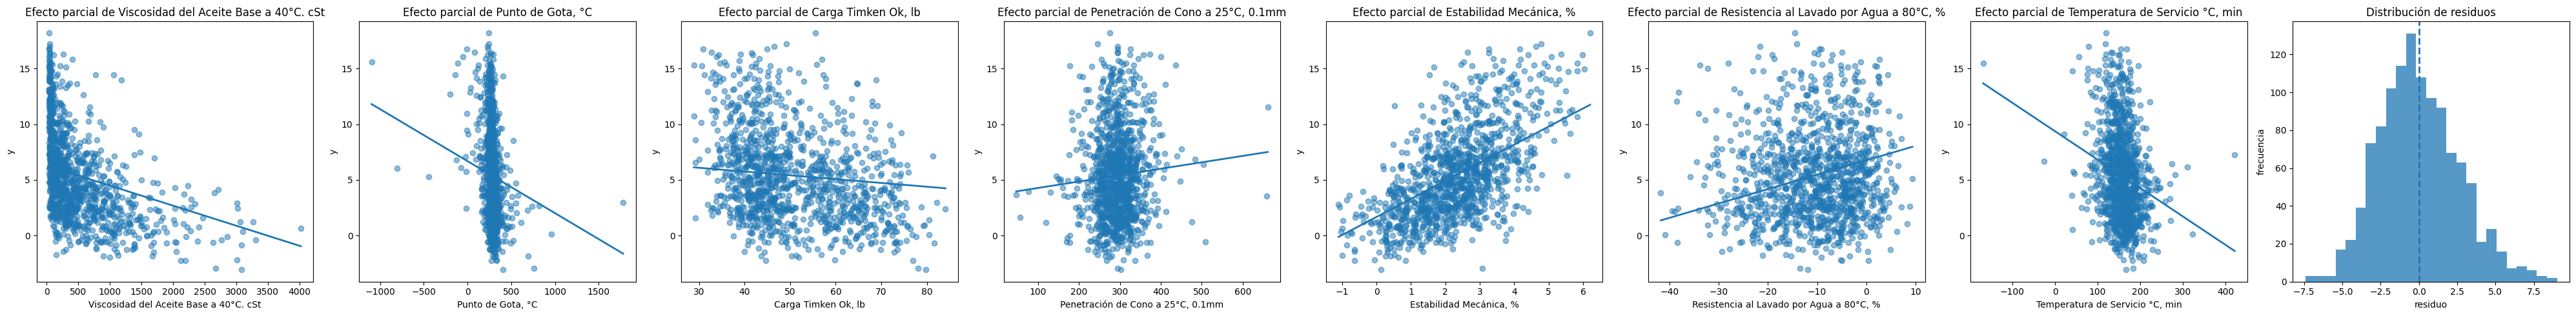

In [25]:
graficar_efectos_parciales(X_final, y, beta_hat, res, reg_vars)